## Predicting phonon with `e3nn`
### Getting started
*   Go to Runtime > Change runtime type, and select GPU.
*   Clone the GitHub repository to access the tutorial files:

*   Install some relevant packages (should take < 1 minute).



### Tutorial

In [1]:
##########################

# Import

##########################
import torch
import time
import pickle as pkl
import random

from utils.utils_load import load_band_structure_data
from utils.utils_data import generate_gamma_data_dict
from utils.utils_model import BandLoss, GraphNetworkVVN, train  #! update
from utils.utils_plot import generate_dafaframe, plot_gphonons, plot_element_count_stack    #! update

torch.set_default_dtype(torch.float64)

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
import pandas as pd

# data visualization
import matplotlib as mpl
from ase.visualize.plot import plot_atoms

sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

In [2]:
##########################

# Parameters (ToDo: move some parameters to the section of GNN model set up)

##########################

run_name = time.strftime('%y%m%d-%H%M%S', time.localtime())
# run_name = '221028-172544'
model_dir = './models'
data_dir = './data'
raw_dir = './data/DFPT_band_structure'
data_file = 'DFPT_band_structure.pkl'

print('torch device: ', device)
print('model name: ', run_name)
print('data_file: ', data_file)

tr_ratio = 0.9
batch_size = 1
k_fold = 5

print('\ndata parameters')
print('method: ', k_fold, '-fold cross validation')
print('training ratio: ', tr_ratio)
print('batch size: ', batch_size)

torch device:  cuda
model name:  221224-080246
data_file:  DFPT_band_structure.pkl

data parameters
method:  5 -fold cross validation
training ratio:  0.9
batch size:  1


In [21]:
##########################

# Parameters (ToDo: move some parameters to the section of GNN model set up)

##########################
# phonon_11320.out
max_iter = 200 #200
lmax = 2 #2
mul = 4 #4
nlayers = 2 #5
r_max = 4 #4
number_of_basis = 10 #10
radial_layers = 1 #1
radial_neurons = 100 #100
node_dim = 118
node_embed_dim = 32 #32
input_dim = 118
input_embed_dim = 32 #32
irreps_out = '1x0e'
option='vvn'

print('\nmodel parameters')
print('max iteration: ', max_iter)
print('max l: ', lmax)
print('multiplicity: ', mul)
print('convolution layer: ', nlayers)
print('cut off radius for neighbors: ', r_max)
print('radial distance bases: ', number_of_basis)
print('radial embedding layers: ', radial_layers)
print('radial embedding neurons per layer: ', radial_neurons)
print('node attribute dimension: ', node_dim)
print('node attribute embedding dimension: ', node_embed_dim)
print('input dimension: ', input_dim)
print('input embedding dimension: ', input_embed_dim)
print('irreduceble output representation: ', irreps_out)
print('Model option: ', option)


model parameters
max iteration:  200
max l:  2
multiplicity:  4
convolution layer:  2
cut off radius for neighbors:  4
radial distance bases:  10
radial embedding layers:  1
radial embedding neurons per layer:  100
node attribute dimension:  118
node attribute embedding dimension:  32
input dimension:  118
input embedding dimension:  32
irreduceble output representation:  1x0e
Model option:  vvn


In [4]:
loss_fn = BandLoss()
lr = 0.005 # random.uniform(0.001, 0.05) #0.005
weight_decay = 0.05 # random.uniform(0.01, 0.5) #0.05
schedule_gamma = 0.96 # random.uniform(0.85, 0.99) #0.96

print('\noptimization parameters')
print('loss function: ', loss_fn)
print('optimization function: AdamW')
print('learning rate: ', lr)
print('weight decay: ', weight_decay)
print('learning rate scheduler: exponentialLR')
print('schedule factor: ', schedule_gamma)


optimization parameters
loss function:  BandLoss()
optimization function: AdamW
learning rate:  0.005
weight decay:  0.05
learning rate scheduler: exponentialLR
schedule factor:  0.96


### Data provenance
We train our model using the database of Density Functional Perturbation Theory (DFPT)-calculated phonon bands, containing approximately 1,500 crystalline solids [[Petretto et al. 2018]](https://doi.org/10.1038/sdata.2018.65).

In [5]:
# load data

##########################

# Load data from pkl or csv
# (DFPT, Kyoto)

##########################

data = load_band_structure_data(data_dir, raw_dir, data_file)
# data = load_data(f'./data/data.csv')
# pkl.dump(data, open(data_dir + f'/data.pkl', 'wb'))

data_dict = generate_gamma_data_dict(data_dir, run_name, data, r_max)   #TODO: complete build_data_vvn function

num = len(data_dict)
tr_nums = [int((num * tr_ratio)//k_fold)] * k_fold
te_num = num - sum(tr_nums)
tr_set, te_set = torch.utils.data.random_split(list(data_dict.values()), [num - te_num, te_num])
# pkl.dump(tr_set, open(data_dir + f'/{run_name}_tr_set.pkl', 'wb'))
# pkl.dump(te_set, open(data_dir + f'/{run_name}_te_set.pkl', 'wb'))

mp-7173
structure_vn.arrays['numbers']:  [21 51 78 26 26 26 26 26 26 26 26 26]
structure_vn.arrays['numbers']:  (12,)
z_emb:  torch.Size([12, 118])
x_emb:  torch.Size([12, 118])
symbols:  ['Sc', 'Sb', 'Pt']
numb:  3
edge_src:  (139,)
gphonon:  (9,)
mp-12317
structure_vn.arrays['numbers']:  [38  6  7  7 26 26 26 26 26 26 26 26 26 26 26 26]
structure_vn.arrays['numbers']:  (16,)
z_emb:  torch.Size([16, 118])
x_emb:  torch.Size([16, 118])
symbols:  ['Sr', 'C', 'N', 'N']
numb:  4
edge_src:  (256,)
gphonon:  (12,)
mp-8300
structure_vn.arrays['numbers']:  [56 56 56 56 33 33  8 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26
 26 26 26 26]
structure_vn.arrays['numbers']:  (28,)
z_emb:  torch.Size([28, 118])
x_emb:  torch.Size([28, 118])
symbols:  ['Ba', 'Ba', 'Ba', 'Ba', 'As', 'As', 'O']
numb:  7
edge_src:  (667,)
gphonon:  (21,)
mp-27193
structure_vn.arrays['numbers']:  [37 53  8  8  8 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26]
structure_vn.arrays['numbers']:  (20,)
z_emb:  torch.Size([

/data1/rokabe/phonondos/phonon_prediction/utils/utils_data.py:209: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_vec = torch.tensor(edge_vec, dtype = torch.float64),


structure_vn.arrays['numbers']:  [37 51  9  9  9  9  9  9 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26
 26 26 26 26 26 26 26 26]
structure_vn.arrays['numbers']:  (32,)
z_emb:  torch.Size([32, 118])
x_emb:  torch.Size([32, 118])
symbols:  ['Rb', 'Sb', 'F', 'F', 'F', 'F', 'F', 'F']
numb:  8
edge_src:  (894,)
gphonon:  (24,)
mp-30460
structure_vn.arrays['numbers']:  [39 28 83 26 26 26 26 26 26 26 26 26]
structure_vn.arrays['numbers']:  (12,)
z_emb:  torch.Size([12, 118])
x_emb:  torch.Size([12, 118])
symbols:  ['Y', 'Ni', 'Bi']
numb:  3
edge_src:  (139,)
gphonon:  (9,)
mp-14039
structure_vn.arrays['numbers']:  [19 19 11 45  9  9  9  9  9  9 26 26 26 26 26 26 26 26 26 26 26 26 26 26
 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26 26]
structure_vn.arrays['numbers']:  (40,)
z_emb:  torch.Size([40, 118])
x_emb:  torch.Size([40, 118])
symbols:  ['K', 'K', 'Na', 'Rh', 'F', 'F', 'F', 'F', 'F', 'F']
numb:  10
edge_src:  (1368,)
gphonon:  (30,)
mp-463
structure_vn.arrays['numbers']:  [19  9 26 26

### Data structures
Crystal structures are represented as [ASE](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=atoms#the-atoms-object) (Atomic Simulation Environment) `Atoms` objects, which store the atomic species and positions of each atom in the unit cell, as well as the lattice vectors of the unit cell.

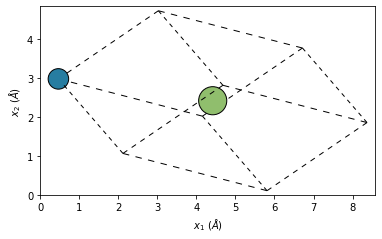

In [6]:
# plot an example structure

##########################

# Visualize the structures
# (DFPT, Kyoto)

##########################

palette = ['#90BE6D', '#277DA1', '#F8961E', '#F94144']
datasets = ['train', 'valid', 'test']
colors = dict(zip(datasets, palette[:-1]))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])

i = 16 # structure index in dataframe

struct = data.iloc[i]['structure']
symbols = np.unique(list(struct.symbols))
z = dict(zip(symbols, range(len(symbols))))

fig, ax = plt.subplots(figsize=(6,5))
norm = plt.Normalize(vmin=0, vmax=len(symbols)-1)
color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in list(struct.symbols)]))]
plot_atoms(struct, ax, radii=0.25, colors=color, rotation=('30x,30y,0z'))

ax.set_xlabel(r'$x_1\ (\AA)$')
ax.set_ylabel(r'$x_2\ (\AA)$');

(array([131.,  89., 134., 102., 139., 102., 255., 104., 255.,  26., 171.,
          0.,   1.,   1.,   8.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 2.  ,  2.95,  3.9 ,  4.85,  5.8 ,  6.75,  7.7 ,  8.65,  9.6 ,
        10.55, 11.5 , 12.45, 13.4 , 14.35, 15.3 , 16.25, 17.2 , 18.15,
        19.1 , 20.05, 21.  , 21.95, 22.9 , 23.85, 24.8 , 25.75, 26.7 ,
        27.65, 28.6 , 29.55, 30.5 , 31.45, 32.4 , 33.35, 34.3 , 35.25,
        36.2 , 37.15, 38.1 , 39.05, 40.  ]),
 <BarContainer object of 40 artists>)

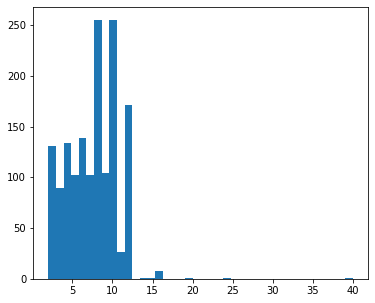

In [7]:
##########################

# data statistics (#Atoms/cell)
sites = [len(s.get_positions()) for s in list(data['structure'])]
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(sites, bins=max(sites))
##########################

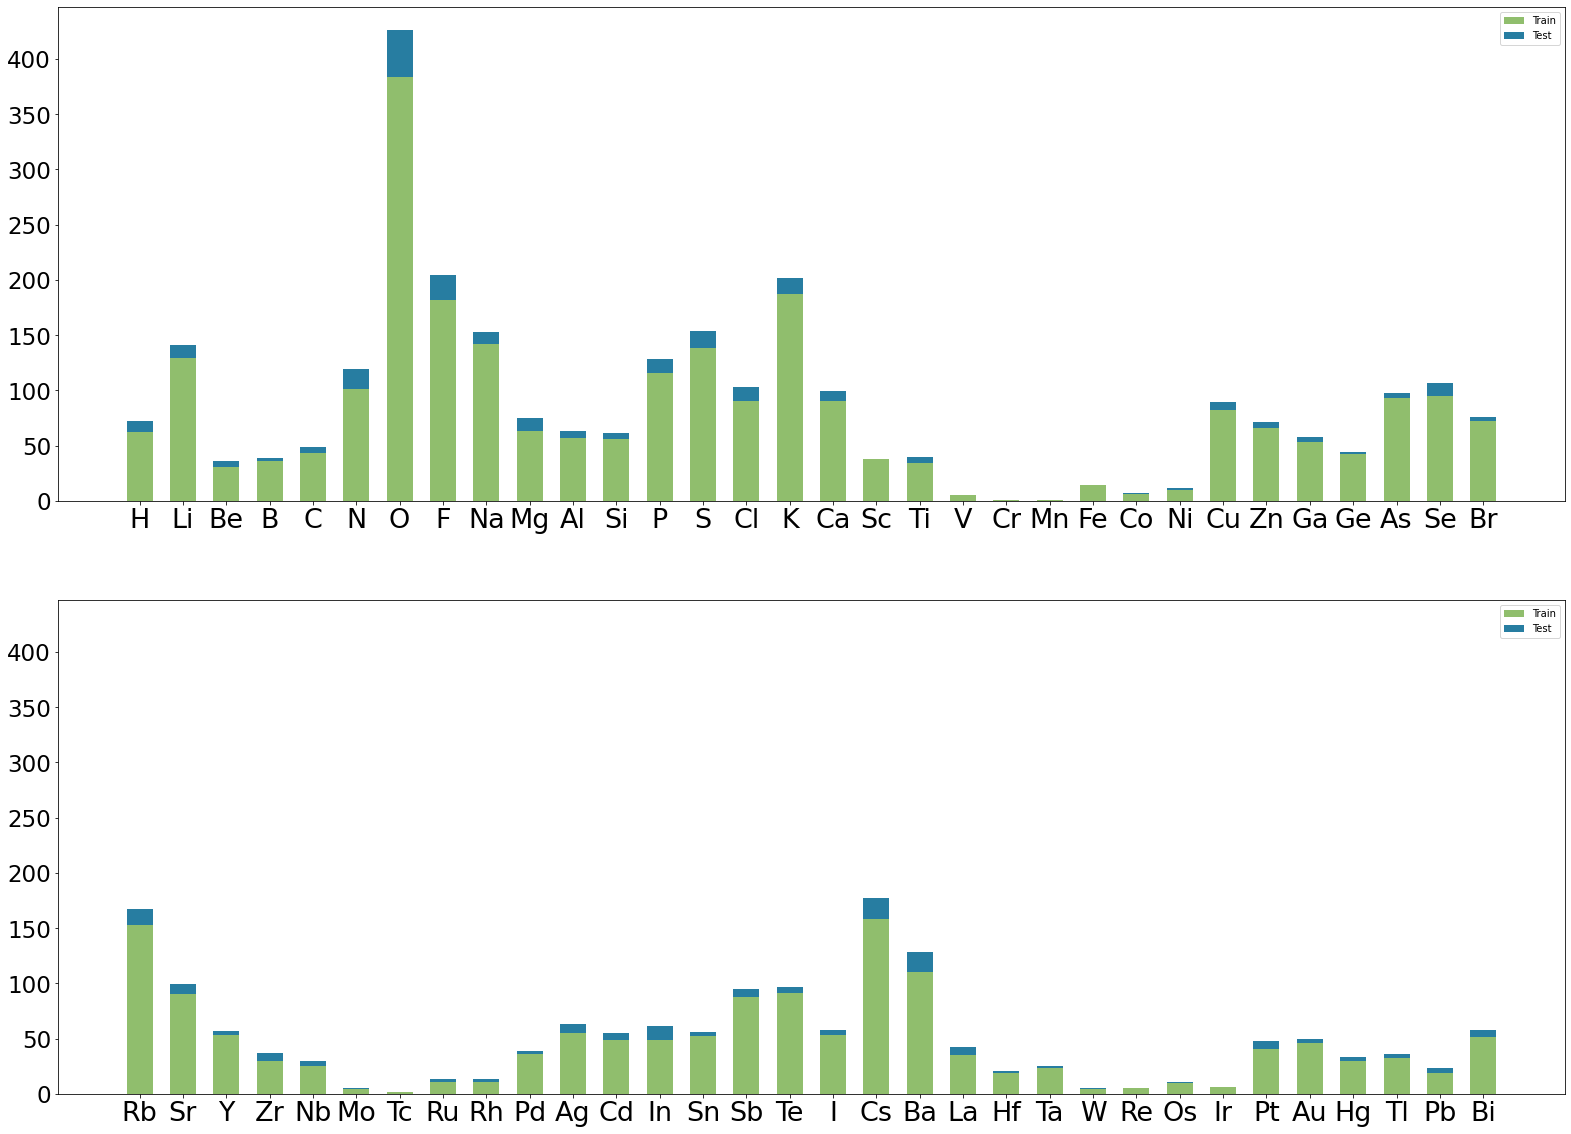

In [8]:
plot_element_count_stack(tr_set, te_set)

average lattice parameter (a/b/c): 5.678426907672584 / 5.746869128415517 / 6.370095102511506


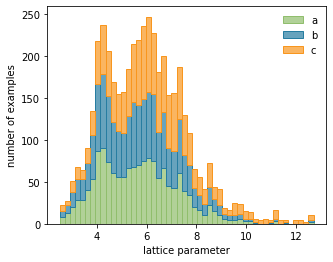

In [9]:
# lattice parameter statistics

##########################

# data statistics (Lattice parameters)

##########################

def get_lattice_parameters(data):
    a = []
    # for entry in df.itertuples():
    #     a.append(entry.structure.cell.cellpar()[:3])
    len_data = len(data)
    for i in range(len_data):
        # print(i)
        d = data.iloc[i]
        # print(d)
        # d_species = set([data.symbol[j] for j in range(len(data.symbol))])
        a.append(d.structure.cell.cellpar()[:3])
    return np.stack(a)

a = get_lattice_parameters(data)

fig, ax = plt.subplots(1,1, figsize=(5,4))
b = 0.
bins = 50
for d, c, n in zip(['a', 'b', 'c'], colors.values(), [a[:,0], a[:,1], a[:,2]]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('lattice parameter')
ax.set_ylabel('number of examples')
ax.legend(frameon=False)

print('average lattice parameter (a/b/c):', a[:,0].mean(), '/', a[:,1].mean(), '/', a[:,2].mean())

### Feature representation
We construct the inputs to our neural network following the `e3nn` [Documentation](https://docs.e3nn.org/en/latest/guide/periodic_boundary_conditions.html) on handling point inputs with periodic boundary conditions. For a given crystal, each atom in the unit cell is associated with a feature vector that one-hot encodes its atomic mass in the index corresponding to its atomic number. The unit cell of the crystal is encoded as a graph in which two atoms (nodes) are joined by an edge if they are within a cutoff radius `r_max` of one another.

### Training, validation, and testing datasets
Split the data into training, validation, and testing datasets with balanced representation of different elements in each set.

For use with the trained model provided, the indices of the training, validation, and test sets are loaded below. These indices were generated with a specific seed using the above `train_valid_test_split` function.

### Network architecture
We build a model based on the `Network` described in the `e3nn` [Documentation](https://docs.e3nn.org/en/latest/api/nn/models/gate_points_2101.html), modified to incorporate the periodic boundaries we imposed on the crystal graphs. The network applies equivariant convolutions to each atomic node and finally takes an average over all nodes, normalizing the output.

In [17]:
##########################

# Model parameters

##########################
model = GraphNetworkVVN(mul,
                     irreps_out,
                     lmax,
                     nlayers,
                     number_of_basis,
                     radial_layers,
                     radial_neurons,
                     node_dim,
                     node_embed_dim,
                     input_dim,
                     input_embed_dim)   #TODO: update the GraphNetwork (or create model with the other name) based on VVN principle. 
print(model)


GraphNetworkVVN(
  (layers): ModuleList(
    (0): CustomCompose(
      (first): GraphConvolution(
        (linear_input): FullyConnectedTensorProduct(32x0e x 32x0e -> 32x0e | 32768 paths | 32768 weights)
        (linear_mask): FullyConnectedTensorProduct(32x0e x 32x0e -> 12x0e+4x1o+4x2e | 12288 paths | 12288 weights)
        (tensor_edge): TensorProduct(32x0e x 1x0e+1x1o+1x2e -> 32x0e+32x1o+32x2e | 96 paths | 96 weights)
        (edge2weight): FullyConnectedNet[10, 100, 96]
        (linear_output): FullyConnectedTensorProduct(32x0e+32x1o+32x2e x 32x0e -> 12x0e+4x1o+4x2e | 20480 paths | 20480 weights)
      )
      (second): Gate (12x0e+4x1o+4x2e -> 4x0e+4x1o+4x2e)
    )
    (1): CustomCompose(
      (first): GraphConvolution(
        (linear_input): FullyConnectedTensorProduct(4x0e+4x1o+4x2e x 32x0e -> 4x0e+4x1o+4x2e | 1536 paths | 1536 weights)
        (linear_mask): FullyConnectedTensorProduct(4x0e+4x1o+4x2e x 32x0e -> 20x0e+4x1o+4x1e+4x2o+4x2e | 3584 paths | 3584 weights)
        (t

### Training
The model is trained using a mean-squared error loss function with an Adam optimizer.

In [11]:
##########################

# optimizer, loss function

##########################

opt = torch.optim.AdamW(model.parameters(), lr = lr, weight_decay = weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma = schedule_gamma)


In [ ]:
##########################

# Training

##########################

train(model,
      opt,
      tr_set,
      tr_nums,
      te_set,
      loss_fn,
      run_name,
      max_iter,
      scheduler,
      device,
      batch_size,
      k_fold,
      option)     #TODO: update the "train" (or create function with the other name) based on VVN principle. 


Use model.load_state_dict to load the existing model: 221205-105251.torch
There is no existing model


RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
RuntimeError: 


In [18]:
# load pre-trained model and plot its training history

##########################

# Load pre-trained model

##########################

model_name = '221223-053254'
model_file = f'./models/{model_name}.torch'
model.load_state_dict(torch.load(model_file)['state'])
model.to(device)
# tr_set  = pkl.load(open(f'{data_dir}/{model_name}_tr_set.pkl', 'rb'))
# te_set  = pkl.load(open(f'{data_dir}/{model_name}_te_set.pkl', 'rb'))
# run_name = 'model'



GraphNetworkVVN(
  (layers): ModuleList(
    (0): CustomCompose(
      (first): GraphConvolution(
        (linear_input): FullyConnectedTensorProduct(32x0e x 32x0e -> 32x0e | 32768 paths | 32768 weights)
        (linear_mask): FullyConnectedTensorProduct(32x0e x 32x0e -> 12x0e+4x1o+4x2e | 12288 paths | 12288 weights)
        (tensor_edge): TensorProduct(32x0e x 1x0e+1x1o+1x2e -> 32x0e+32x1o+32x2e | 96 paths | 96 weights)
        (edge2weight): FullyConnectedNet[10, 100, 96]
        (linear_output): FullyConnectedTensorProduct(32x0e+32x1o+32x2e x 32x0e -> 12x0e+4x1o+4x2e | 20480 paths | 20480 weights)
      )
      (second): Gate (12x0e+4x1o+4x2e -> 4x0e+4x1o+4x2e)
    )
    (1): CustomCompose(
      (first): GraphConvolution(
        (linear_input): FullyConnectedTensorProduct(4x0e+4x1o+4x2e x 32x0e -> 4x0e+4x1o+4x2e | 1536 paths | 1536 weights)
        (linear_mask): FullyConnectedTensorProduct(4x0e+4x1o+4x2e x 32x0e -> 20x0e+4x1o+4x1e+4x2o+4x2e | 3584 paths | 3584 weights)
        (t

### Results
We evaluate our model by visualizing the predicted and true DoS in each error quartile. We further compare the hidden features learned for each node to the partial DoS.

In [19]:
# Generate Data Loader
tr_loader = DataLoader(tr_set, batch_size = batch_size)
te1_loader = DataLoader(te_set, batch_size = batch_size)

In [22]:
# Generate Data Frame
df_tr = generate_dafaframe(model, tr_loader, loss_fn, device, option)   #TODO: check if we can use the same function as the case of kMVN model. 
df_te1 = generate_dafaframe(model, te1_loader, loss_fn, device, option)

[]


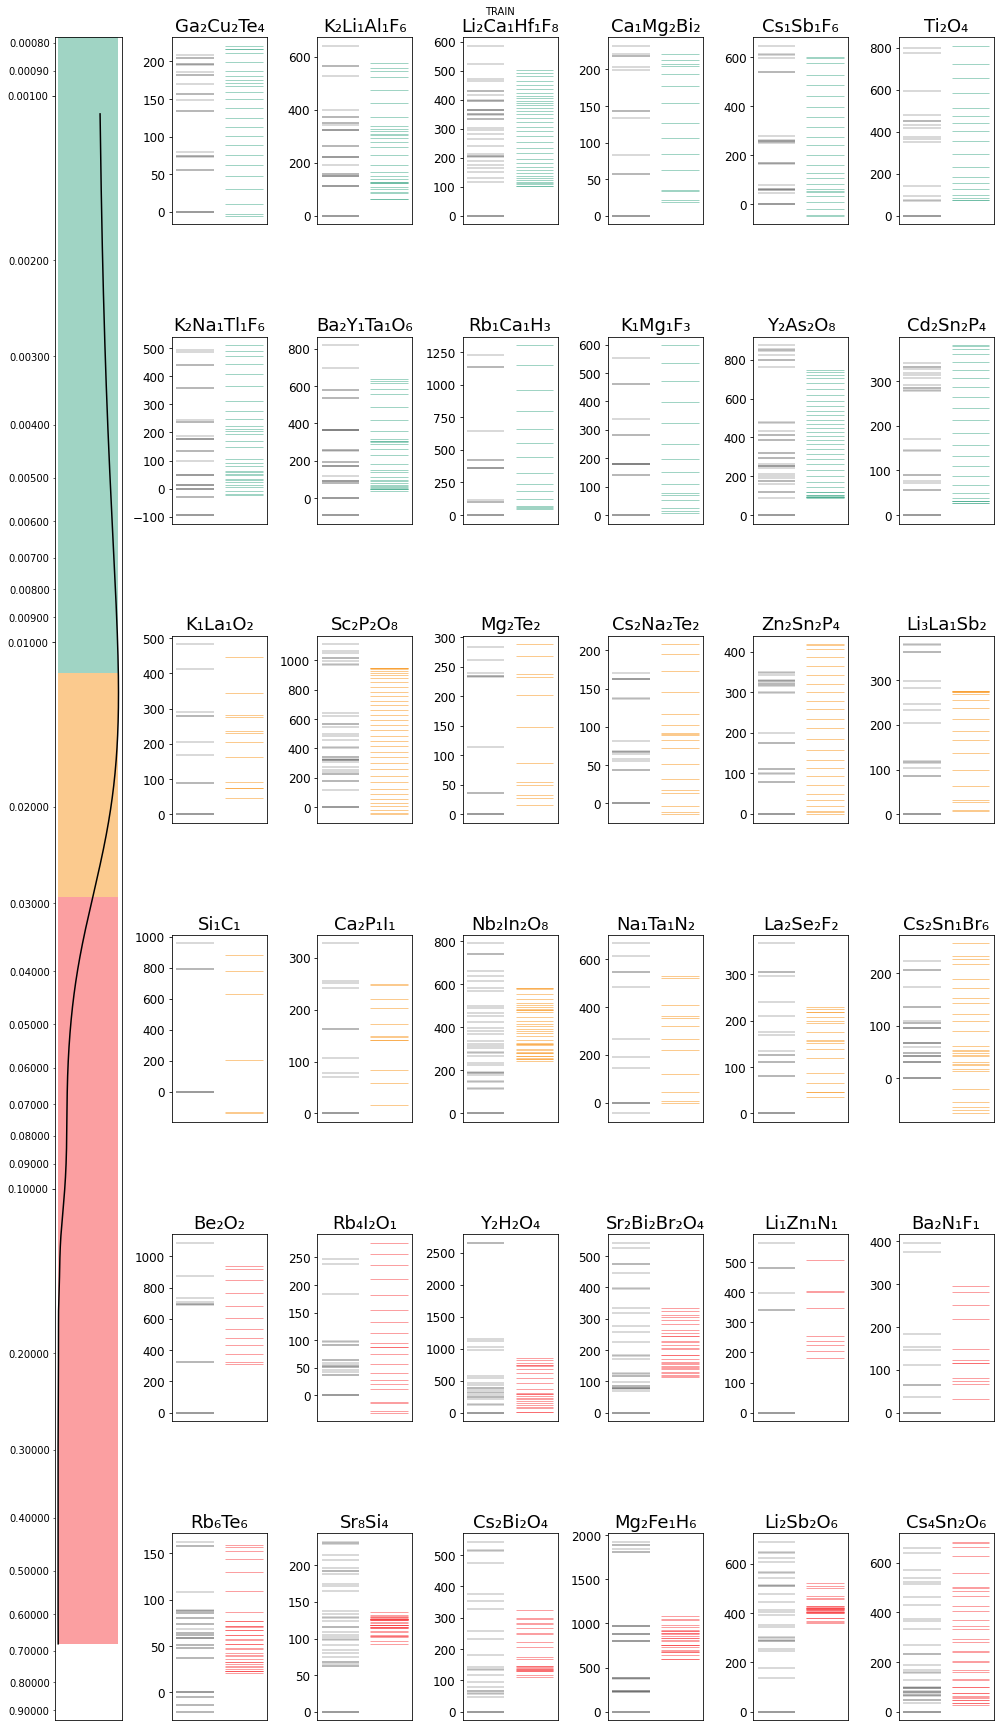

In [32]:
# Plot the bands of TRAIN data
palette = ['#43AA8B', '#F8961E', '#F94144', '#277DA1']
plot_gphonons(df_tr, header=None, title='TRAIN', n=6, m=2, palette=palette)

In [33]:
# Plot the bands of TEST data
palette = ['#43AA8B', '#F8961E', '#F94144', '#277DA1']
plot_gphonons(df_te1, header=None, title='TEST', n=6, m=2, palette=palette)

TypeError: plot_gphonons() got an unexpected keyword argument 'fig_header'